In [20]:
"""
Implements an RNN on a synthetic data set, following the architecture 
described in "Deep Knowledge Tracing" by Chris Piech et al.
The RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).
BSD License
"""

'\nImplements an RNN on a synthetic data set, following the architecture \ndescribed in "Deep Knowledge Tracing" by Chris Piech et al.\nThe RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).\nBSD License\n'

In [21]:
import numpy as np
import random
import sys

import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

synthetic_data_set = "syntheticDetailed/naive_c5_q50_s4000_v0.csv"
code_org_data_set = "data/hoc_1-9_binary_input.csv"

DATA_SET = code_org_data_set

In [22]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(DATA_SET,"rb"),delimiter=','))).astype('int')
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 
# Split data into train and test (half and half)
num_samples = 6000  # Note: for code.org sample, enforcing limit on num_students as a trial
train = data_array[0:num_samples/2,:]
test = data_array[num_samples/2:num_samples,:]

num_train = train.shape[0]
num_test = test.shape[0]


print('Vectorization...')
X_train = np.zeros((num_train, num_timesteps, num_problems * 2), dtype=np.bool)
y_train = np.zeros((num_train, num_timesteps), dtype=np.int)

# Create 3-dimensional input tensor with one-hot encodings for each sample
# the dimension of each vector for a student i and time t is 2 * num_problems
# where the first half corresponds to the correctly answered problems and the
# second half to the incorrectly answered ones.
for i in xrange(num_train):
    
    # for the first time step. Done separately so we can populate the output 
    # tensor at the same time, which is shifted back by 1.

    for t in xrange(0,num_timesteps):
        p = t # since timestep t corresponds to problem p where t=p
        if train[i,p] == 1:
            X_train[i, t, p] = 1 
        else:
            X_train[i, t, num_problems + p] = 1
        # this is a special case for the synthetic data set, where the next problem 
        # is just the current problem index + 1
        y_train[i,t] = p + 1
correctness = train

print ("Vectorization done!")

print ("X_train")
print (X_train.shape)
print (X_train[:5])

print ("y_train")
print (y_train.shape)
print (y_train[:5])

Vectorization...
Vectorization done!
X_train
(3000, 8, 18)
[[[ True False False False False False False False False False False False
   False False False False False False]
  [False False False False False False False False False False  True False
   False False False False False False]
  [False False  True False False False False False False False False False
   False False False False False False]
  [False False False  True False False False False False False False False
   False False False False False False]
  [False False False False  True False False False False False False False
   False False False False False False]
  [False False False False False False False False False False False False
   False False  True False False False]
  [False False False False False False  True False False False False False
   False False False False False False]
  [False False False False False False False  True False False False False
   False False False False False False]]

 [[ True False Fals

In [28]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-1
epochs = 4

# model parameters
Wxh = np.random.randn(hidden_size, num_problems * 2)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(num_problems, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((num_problems, 1)) # output bias

def lossFun(inputs, targets, correctness, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars

        # softmax (cross-entropy loss)
        if correctness[targets[t]] == 1:
            loss += -np.log(ps[t][targets[t],0]) 
        else:
            loss += -np.log(1-ps[t][targets[t],0]) 
        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dhnext = np.zeros_like(hs[0])


    for t in reversed(xrange(len(inputs))):
        dy = np.copy(ps[t])
        if correctness[targets[t]] == 1:
            dy[targets[t]] -= 1 # backprop into y
        else:
            for p in xrange(num_problems):
                if p != targets[t]:
                    dy[p] -= np.exp(ys[t][p]) / (ps_denom[t] - np.exp(ys[t][targets[t]]))



        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


In [29]:
def accuracy(ps, targets, correctness):
    """
    Computes the accuracy using the predictions at each time step.
    For each t, if probability of next problem is > 0.5 for correct, or <= 0.5 
    for incorrect, then count this as correct prediction.
    """
    num_correct = 0
    for t in xrange(num_timesteps):
        predicted_prob = ps[t][targets[t],0] 
        if (predicted_prob >= 0.5 and correctness[targets[t]] == 1) or (predicted_prob < 0.5 and correctness[targets[t]] == 0):
            num_correct += 1
    accuracy = num_correct / float(num_timesteps)
    return accuracy

def forward_pass(inputs):
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars
    return ps

In [ ]:
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/num_problems)*num_timesteps # loss at iteration 0

losses = []
accuracies = []
for e in xrange(epochs):
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    total_acc = 0.0
    for i in xrange(num_train):
        inputs = X_train[i,:,:].reshape((num_timesteps, num_problems * 2))
        targets = y_train[i,:].reshape((num_timesteps,))
        correctness_for_student = correctness[i,:].reshape((num_problems))

        # forward num_timesteps characters through the net and fetch gradient
        loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, correctness_for_student, hprev)
        smooth_loss = smooth_loss * 0.7 + loss * 0.3
        losses.append(smooth_loss)

        # perform parameter update with Adagrad
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                      [dWxh, dWhh, dWhy, dbh, dby], 
                                      [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
        ps = forward_pass(inputs)
        acc = accuracy(ps, targets, correctness_for_student) 
        accuracies.append(acc)
        print ('epoch %d, iter %d, loss: %f, acc: %f' % (e, i, smooth_loss, acc)) # print progress
        total_acc += acc
    total_acc /= num_train
    print ('epoch %d, acc: %f' % (e, total_acc)) # print progress
    

epoch 0, iter 0, loss: 15.705842, acc: 0.375000
epoch 0, iter 1, loss: 16.155638, acc: 0.000000
epoch 0, iter 2, loss: 25.771221, acc: 0.500000
epoch 0, iter 3, loss: 37.664147, acc: 0.000000
epoch 0, iter 4, loss: 53.221131, acc: 0.125000
epoch 0, iter 5, loss: 59.194243, acc: 0.375000
epoch 0, iter 6, loss: 43.648012, acc: 1.000000
epoch 0, iter 7, loss: 42.385364, acc: 0.625000
epoch 0, iter 8, loss: 33.445945, acc: 0.750000
epoch 0, iter 9, loss: 30.693789, acc: 0.625000
epoch 0, iter 10, loss: 29.719503, acc: 0.500000
epoch 0, iter 11, loss: 35.749213, acc: 0.500000
epoch 0, iter 12, loss: 34.207329, acc: 0.500000
epoch 0, iter 13, loss: 30.941807, acc: 0.500000
epoch 0, iter 14, loss: 27.197396, acc: 0.625000
epoch 0, iter 15, loss: 22.862665, acc: 0.875000
epoch 0, iter 16, loss: 23.424256, acc: 0.375000
epoch 0, iter 17, loss: 18.967406, acc: 0.750000
epoch 0, iter 18, loss: 19.222953, acc: 0.500000
epoch 0, iter 19, loss: 18.837572, acc: 0.625000
epoch 0, iter 20, loss: 17.198

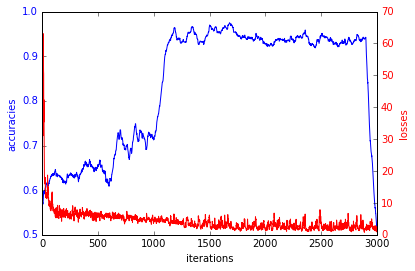

In [26]:
smooth_accs = []

smooth_window = 100
for i in xrange(len(accuracies)-smooth_window):
    smooth_accs.append(np.mean(accuracies[i:i+smooth_window]))

for i in xrange(len(accuracies)-smooth_window, len(accuracies)):
    smooth_accs.append(np.mean(accuracies[i:len(accuracies)]))
                    
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(xrange(len(smooth_accs)/2), smooth_accs[:len(smooth_accs)/2], 'b-')
ax1.set_ylabel('accuracies', color='b')
ax1.set_xlabel('iterations')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(xrange(len(losses)/2), losses[:len(losses)/2], 'r-')
ax2.set_ylabel('losses', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.show()

In [27]:
figure_filename = "loss_plots/test.png"
fig.savefig(figure_filename)